![metodology](https://www.muycomputerpro.com/wp-content/uploads/2019/03/machine_learning_train.jpeg)

## Cargar el Dataset

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("Dataset/kalowoodsman.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17017 entries, 0 to 17016
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   User    17017 non-null  object
 1   Text    17017 non-null  object
 2   Groom   17017 non-null  bool  
dtypes: bool(1), object(2)
memory usage: 282.6+ KB


In [3]:
from sklearn.preprocessing import LabelEncoder
num_encoder = LabelEncoder()
df['Groom'] = num_encoder.fit_transform(df['Groom']).astype('int')
#df['Text'] = num_encoder.fit_transform(df['Text']).astype('int')
df

,User,Text,Groom
0,kalowoodsman,youre all kinds of gorgeous,1
1,keri,hi,0
2,keri,do i know u,0
3,kalowoodsman,no just dropping you a compliment liked what i...,1
4,keri,ty lol,0
...,...,...,...
17012,kalowoodsman,would you even want to be my wife,1
17013,13-yr-old-girl,yea,0
17014,13-yr-old-girl,if ur nice 2 me,0
17015,kalowoodsman,ill be back on a little later i think stay safe,1


## Extracción y selección de características del texto
Convertir texto en una matriz de tokens contables 

In [4]:
#from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2

df_pos, df_neg = df[df['Groom']==1][:6000], df[df['Groom']==0][:6000]
new_df = pd.concat([df_pos, df_neg])
new_df.value_counts('Groom')

In [5]:
from nltk.corpus import stopwords
stpw = stopwords.words('english')
stpws = open('en-stopwords.txt', 'r').readlines()
stpw.extend(stpws)
stemmer = SnowballStemmer('english')

def processing_text(text):
    words = word_tokenize(text)
    words = [k for k in words if k not in stpw]
    words = ' '.join(str(k) for k in words)
    return words

In [6]:
#CV = CountVectorizer()
TF_IDF = TfidfVectorizer(ngram_range=(1,2), stop_words=stpw)
KChi = SelectKBest(chi2, k=20)

In [7]:
X, y = df['Text'].values, df['Groom'].values

In [29]:
X_vect = TF_IDF.fit_transform(X)

(17017, 18736)


In [67]:
TF_IDF.get_feature_names().count(TF_IDF.get_stop_words())

0

In [41]:
TF_IDF.inverse_transform(X_vect)[3]

array(['liked saw', 'compliment liked', 'dropping compliment', 'saw',
       'liked', 'compliment', 'dropping'], dtype='<U30')

In [39]:
df.Text.loc[3]

'no just dropping you a compliment liked what i saw of you'

## Dividir el conjunto de datos en entrenamiento y prueba
Retenemos algún subconjunto de los datos del entrenamiento del modelo y luego usamos este conjunto de reserva para verificar el rendimiento del modelo

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
#X, y = df['Text'].values, df['Groom'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

## Determinar parámetros para el clasificador ##

In [83]:
vect = TF_IDF.fit_transform(X_train,y_train)
len(vect.toarray())

13508

In [84]:
best = KChi.fit_transform(vect, y_train)
len(best.toarray())

13508

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler

## Pasar los datos al clasificador ##

In [11]:
from sklearn.naive_bayes import MultinomialNB # Clasificador de Naive Bayes
from sklearn.svm import SVC # Clasificador de Suport Vector Machine
from sklearn.ensemble import RandomForestClassifier # Clasificador de Bosques Aleatorios

In [12]:
#params = {'n_grams': [(1,2), (2,3)]}
#X_vect = TF_IDF.fit_transform(X_train)
#X_new = SelectKBest(chi2, k=20).fit_transform(X_vect, y_train)
modelMNB = make_pipeline(TfidfVectorizer(ngram_range=(1,2)), MultinomialNB())
#grid = GridSearchCV(pipe_MNB, params, cv=5, scoring='accuracy')
modelSVM = make_pipeline(TfidfVectorizer(ngram_range=(1,2)), SVC(probability=True))
modelRFC = make_pipeline(TfidfVectorizer(ngram_range=(1,2)), RandomForestClassifier())

In [40]:
#TF_IDF.fit_transform(X_train)

In [13]:
%timeit modelMNB.fit(X_train, y_train)

261 ms ± 29.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%timeit modelSVM.fit(X_train, y_train)

54.9 s ± 4.61 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%timeit modelRFC.fit(X_train, y_train)

20.8 s ± 2.76 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
#X_tvect = TF_IDF.transform(X_test)
from sklearn.model_selection import cross_val_score

cross_val_score(modelMNB, X, y, cv=5, scoring='accuracy').mean()

0.8758868496829887

In [20]:
cross_val_score(modelSVM, X, y, cv=5, scoring='accuracy').mean()

0.8828206279999999


In [21]:
cross_val_score(modelRFC, X, y, cv=5, scoring='accuracy').mean()

0.8699511697876312

In [191]:
from sklearn.model_selection import cross_val_predict

cross_val_predict(modelMNB, X_train, y_train, cv=5)

array([0, 0, 0, ..., 0, 0, 0])

In [192]:
cross_val_predict(modelSVM, X_train, y_train, cv=5)

array([0, 0, 0, ..., 0, 0, 0])

In [193]:
cross_val_predict(modelRFC, X_train, y_train, cv=5)

array([0, 0, 0, ..., 0, 0, 0])

In [22]:
Y_predMNB = modelMNB.predict(X_test)

In [23]:
Y_predSVM = modelSVM.predict(X_test)

In [24]:
Y_predRFC = modelRFC.predict(X_test)

## Evaluar el modelo

### Matriz de confisuión
Las filas de la matriz indican la clase real y las columnas las clases predichas.
La matriz de confusión en si misma no es una medida de rendimiento, pero casi todas la métricas se basan en ellas.
1. **Verdaderos positivos:** Son los casos donde los datos reales son 1 y la predicción es 1
2. **Verdaderos negativos:** Son los casos donde los datos reales son 0 y la predicción es 0
3. **Falsos positivos:** Son los casos donde los datos reales son 0 y la predicción es 1
4. **Falsos negativos:** Son los casos donde los datos reales son 1 y la predicción es 0

### Métricas de evaluación

1. **Exacitud:** Es el número de predicciones correctas realizadas por el modelo por el número total de registros
2. **Precisión:** Evalua los datos por su desempeño de predicciones positivas
3. **Sensibilidad o Recall:** Se calcula como el número de predicciones positivas correctas dividido por el número total de positivos
4. **Especificidad:** Se calcula como el número de predicciones negativas correctas dividido por el número total de negativos
5. **Puntaje F1:** Es el promedio ponderado de precisión y sensibilidad

### Curva ROC y Área Bajo la Curva (AUC)

1. **Características del funcionamiento del receptor (ROC):** Nos dice que tan bien puede distinguir el modelo entre dos clases
2. **Área bajo la curva (AUC):** Nos dice que tan bien funciona el modelo

In [25]:
from sklearn.metrics import *

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

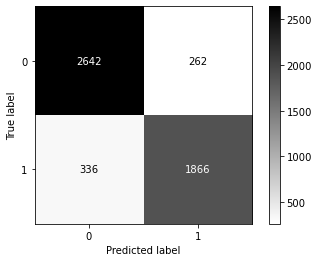

In [27]:
confusion_matrix(y_test, Y_predMNB)
plot_confusion_matrix(modelMNB, X_test, y_test, cmap=plt.cm.binary)
plt.show()

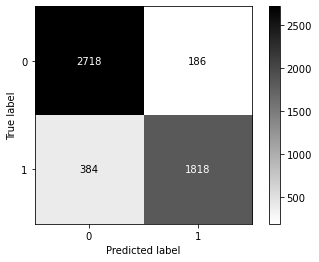

In [28]:
confusion_matrix(y_test, Y_predSVM)
plot_confusion_matrix(modelSVM, X_test, y_test, cmap=plt.cm.binary)
plt.show()

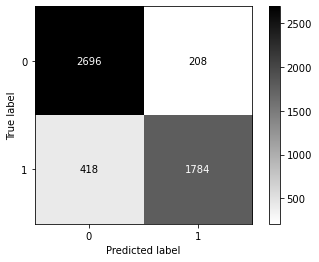

In [29]:
confusion_matrix(y_test, Y_predRFC)
plot_confusion_matrix(modelRFC, X_test, y_test, cmap=plt.cm.binary)
plt.show()

In [30]:
print(classification_report(y_test, Y_predMNB)) # Reporte Clasificador Naive Bayes

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      2904
           1       0.88      0.85      0.86      2202

    accuracy                           0.88      5106
   macro avg       0.88      0.88      0.88      5106
weighted avg       0.88      0.88      0.88      5106



In [31]:
print(classification_report(y_test, Y_predSVM)) # Reporte Clasificador SVM

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      2904
           1       0.91      0.83      0.86      2202

    accuracy                           0.89      5106
   macro avg       0.89      0.88      0.88      5106
weighted avg       0.89      0.89      0.89      5106



In [32]:
print(classification_report(y_test, Y_predRFC)) # Reporte Clasificador Random Forest

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      2904
           1       0.90      0.81      0.85      2202

    accuracy                           0.88      5106
   macro avg       0.88      0.87      0.87      5106
weighted avg       0.88      0.88      0.88      5106



In [33]:
print(f"Error absoluto medio [NB]: {(mean_absolute_error(y_test.astype('int'), Y_predMNB.astype('int'))*100).round(2)}%")
print(f"Puntaje R^2 [NB]: {(r2_score(y_test.astype('int'), Y_predMNB.astype('int'))*100).round(2)}%")

Error absoluto medio [NB]: 11.71%
Puntaje R^2 [NB]: 52.25%


In [34]:
print(f"Error absoluto medio [SVM]: {(mean_absolute_error(y_test.astype('int'), Y_predSVM.astype('int'))*100).round(2)}%")
print(f"Puntaje R^2 [SVM]: {(r2_score(y_test.astype('int'), Y_predSVM.astype('int'))*100).round(2)}%")

Error absoluto medio [SVM]: 11.16%
Puntaje R^2 [SVM]: 54.49%


In [35]:
print(f"Error absoluto medio [RFC]: {(mean_absolute_error(y_test.astype('int'), Y_predRFC.astype('int'))*100).round(2)}%")
print(f"Puntaje R^2 [RFC]: {(r2_score(y_test.astype('int'), Y_predRFC.astype('int'))*100).round(2)}%")

Error absoluto medio [RFC]: 12.26%
Puntaje R^2 [RFC]: 50.01%


In [36]:
print("Conjunto de datos:", df.shape, df['Groom'].shape)
print("Conjunto de entrenamiento:", X_train.shape, y_train.shape)
print("Conjunto de prueba:", X_test.shape, y_test.shape)

Conjunto de datos: (17017, 3) (17017,)
Conjunto de entrenamiento: (11911,) (11911,)
Conjunto de prueba: (5106,) (5106,)


In [37]:
print("Métricas de evaluación del modelo Naive Bayes:\n")
print(f"Exactitud: {(accuracy_score(y_test, Y_predMNB)*100).round(2)}%")
print(f"Precisión: {(precision_score(y_test, Y_predMNB)*100).round(2)}%")
print(f"Recuerdo: {(recall_score(y_test, Y_predMNB)*100).round(2)}%")
print(f"Puntuación F1: {(f1_score(y_test, Y_predMNB)*100).round(2)}%")
print(f"Sensibilidad: {(recall_score(y_test, Y_predMNB)*100).round(2)}%")
#print(f"Precision de clasificacion top: {(top_k_accuracy_score(y_test, y_pred_probMNB, k=2)*100).round(2)}%")
print(f"Perdida de clasificación: {(zero_one_loss(y_test, Y_predMNB)*100).round(2)}%")

Métricas de evaluación del modelo Naive Bayes:

Exactitud: 88.29%
Precisión: 87.69%
Recuerdo: 84.74%
Puntuación F1: 86.19%
Sensibilidad: 84.74%
Perdida de clasificación: 11.71%


In [38]:
print("Métricas de evaluación del modelo Suport Vector Machine:\n")
print(f"Exactitud: {(accuracy_score(y_test, Y_predSVM)*100).round(2)}%")
print(f"Precisión: {(precision_score(y_test, Y_predSVM)*100).round(2)}%")
print(f"Recuerdo: {(recall_score(y_test, Y_predSVM)*100).round(2)}%")
print(f"Puntuación F1: {(f1_score(y_test, Y_predSVM)*100).round(2)}%")
print(f"Sensibilidad: {(recall_score(y_test, Y_predSVM)*100).round(2)}%")
#print(f"Precision de clasificacion top: {(top_k_accuracy_score(y_test, y_pred_probSVM, k=2)*100).round(2)}%")
print(f"Perdida de clasificación: {(zero_one_loss(y_test, Y_predSVM)*100).round(2)}%")

Métricas de evaluación del modelo Suport Vector Machine:

Exactitud: 88.84%
Precisión: 90.72%
Recuerdo: 82.56%
Puntuación F1: 86.45%
Sensibilidad: 82.56%
Perdida de clasificación: 11.16%


In [39]:
print("Métricas de evaluación del modelo Random Forest:\n")
print(f"Exactitud: {(accuracy_score(y_test, Y_predRFC)*100).round(2)}%")
print(f"Precisión: {(precision_score(y_test, Y_predRFC)*100).round(2)}%")
print(f"Recuerdo: {(recall_score(y_test, Y_predRFC)*100).round(2)}%")
print(f"Puntuación F1: {(f1_score(y_test, Y_predRFC)*100).round(2)}%")
print(f"Sensibilidad: {(recall_score(y_test, Y_predRFC)*100).round(2)}%")
#print(f"Precision de clasificacion top: {(top_k_accuracy_score(y_test, y_pred_probMNB, k=2)*100).round(2)}%")
print(f"Perdida de clasificación: {(zero_one_loss(y_test, Y_predRFC)*100).round(2)}%")

Métricas de evaluación del modelo Random Forest:

Exactitud: 87.74%
Precisión: 89.56%
Recuerdo: 81.02%
Puntuación F1: 85.07%
Sensibilidad: 81.02%
Perdida de clasificación: 12.26%


In [41]:
y_pred_probMNB = modelMNB.predict_proba(X_test)[:,1]

In [42]:
y_pred_probSVM = modelSVM.predict_proba(X_test)[:,1]

In [43]:
y_pred_probRFC = modelRFC.predict_proba(X_test)[:,1]

Puntaje AUC [NB]: 94.78%


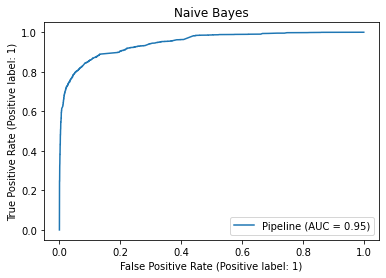

In [44]:
print(f"Puntaje AUC [NB]: {((roc_auc_score(y_test, y_pred_probMNB))*100).round(2)}%")
plot_roc_curve(modelMNB, X_test, y_test)
plt.title('Naive Bayes')
plt.show()

Puntaje AUC [SVM]: 93.28%


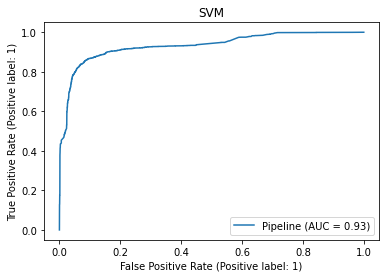

In [45]:
print(f"Puntaje AUC [SVM]: {((roc_auc_score(y_test, y_pred_probSVM))*100).round(2)}%")
plot_roc_curve(modelSVM, X_test, y_test)
plt.title('SVM')
plt.show()

Puntaje AUC [RF]: 93.64%


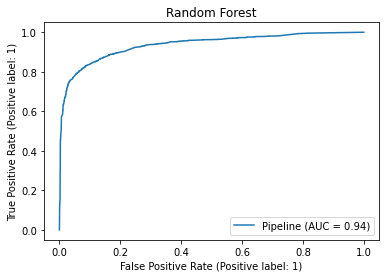

In [46]:
print(f"Puntaje AUC [RF]: {((roc_auc_score(y_test, y_pred_probRFC))*100).round(2)}%")
plot_roc_curve(modelRFC, X_test, y_test)
plt.title('Random Forest')
plt.show()

## Probar los modelos

In [47]:
msg_prob = modelMNB.predict_proba(["i unchap your brassiere and let it fall to the floor"])
msg_pred = modelMNB.predict(["i unchap your brassiere and let it fall to the floor"])
print(f"El algoritmo Naive Bayes clasifica el mensaje como: {msg_pred[0]} con una confianza del {msg_prob[0][0]:.4f}% para NoGroomer y {msg_prob[0][1]:.4f}% para Groomer")

El algoritmo Naive Bayes clasifica el mensaje como: 1 con una confianza del 0.1456% para NoGroomer y 0.8544% para Groomer


In [48]:
msg_prob = modelSVM.predict_proba(["i unchap your brassiere and let it fall to the floor"])
msg_pred = modelSVM.predict(["i unchap your brassiere and let it fall to the floor"])
print(f"El algoritmo SVM clasifica el mensaje como: {msg_pred[0]} con una confianza del {msg_prob[0][0]:.4f}% para NoGroomer y {msg_prob[0][1]:.4f}% para Groomer")

El algoritmo SVM clasifica el mensaje como: 1 con una confianza del 0.0120% para NoGroomer y 0.9880% para Groomer


In [49]:
msg_prob = modelRFC.predict_proba(["i unchap your brassiere and let it fall to the floor"])
msg_pred = modelRFC.predict(["i unchap your brassiere and let it fall to the floor"])
print(f"El algoritmo Random Forest clasifica el mensaje como: {msg_pred[0]} con una confianza del {msg_prob[0][0]:.4f}% para NoGroomer y {msg_prob[0][1]:.4f}% para Groomer")

El algoritmo Random Forest clasifica el mensaje como: 1 con una confianza del 0.2900% para NoGroomer y 0.7100% para Groomer


In [50]:
from win10toast import ToastNotifier
toast = ToastNotifier()

In [51]:
def groom_classifier(*msg, model):
    msg_pred = model.predict(msg)
    if msg_pred*100 > 80:
        toast.show_toast("Alert", "Grooming content in chat!", duration=5)
        #print("Grooming content in chat!")
    else:
        print("None")

In [52]:
groom_classifier("Send me a pic of your homework please", model=modelMNB)

In [53]:
groom_classifier("Send me a pic of your homework please", model=modelSVM)

In [54]:
groom_classifier("Send me a pic of your homework please", model=modelRFC)

In [61]:
#!jupyter nbconvert --to webpdf --allow-chromium-download TestClassifiers.ipynb

In [56]:
import joblib
joblib.dump(modelSVM, 'GroomerClassifier.pkl')

['GroomerClassifier.pkl']

In [60]:
clf = joblib.load('GroomerClassifier.pkl')

In [63]:
clf.predict(['We will pass the semester'])

array([0])